In [1]:
import sys
from numpy import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import operator
%matplotlib inline

In [2]:
df = pd.read_csv("LoanStats3d.csv",skiprows=1,low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421097 entries, 0 to 421096
Columns: 137 entries, id to hardship_last_payment_amount
dtypes: float64(104), object(33)
memory usage: 440.1+ MB


In [3]:
blank_columns = df.columns[df.isnull().all()].tolist()
blank_columns

['member_id',
 'url',
 'revol_bal_joint',
 'sec_app_earliest_cr_line',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_open_acc',
 'sec_app_revol_util',
 'sec_app_open_il_6m',
 'sec_app_num_rev_accts',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_mths_since_last_major_derog']

In [4]:
# drop blank columns
df = df.drop(['id','member_id', 'url','revol_bal_joint','sec_app_earliest_cr_line','sec_app_inq_last_6mths','sec_app_mort_acc',
 'sec_app_open_acc','sec_app_revol_util','sec_app_open_il_6m','sec_app_num_rev_accts','sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med','sec_app_mths_since_last_major_derog'], axis = 1)

# drop post loan variables
df = df.drop(['out_prncp','out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
              'grade', 'sub_grade','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee',
              'collection_recovery_fee','last_pymnt_d','last_pymnt_amnt','next_pymnt_d','last_credit_pull_d',
              'payment_plan_start_date','issue_d'], axis = 1)
df = df.drop(['term','int_rate','installment'], axis = 1)

# drop hardship variables
df = df.drop(['hardship_flag','hardship_type','hardship_reason', 'hardship_status','hardship_start_date',
             'hardship_end_date','hardship_loan_status', 'hardship_amount','hardship_length','hardship_dpd',
              'hardship_payoff_balance_amount','hardship_last_payment_amount'], axis = 1)

## Object variable wrangling
### a. Target variable: How many class of loan status are there?

In [5]:
obj_df = df.select_dtypes(include=['object']).copy()
pd.unique(obj_df['loan_status'].values.ravel())

array(['Current', 'Fully Paid', 'Charged Off', 'Late (16-30 days)',
       'Late (31-120 days)', 'In Grace Period', 'Default', nan], dtype=object)

In [6]:
# classified loan_status to "good loan" and "bad loan''
status_dict = {'loan_status': {'Current':'good loan', 'Fully Paid':'good loan', 'In Grace Period':'good loan', 'Charged Off':'bad loan', 'Late (16-30 days)':'bad loan',
                'Late (31-120 days)':'bad loan', 'Default':'bad loan'}}
obj_df.replace(status_dict, inplace=True)
obj_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421097 entries, 0 to 421096
Data columns (total 16 columns):
emp_title                    397221 non-null object
emp_length                   421095 non-null object
home_ownership               421095 non-null object
verification_status          421095 non-null object
loan_status                  421095 non-null object
pymnt_plan                   421095 non-null object
desc                         45 non-null object
purpose                      421095 non-null object
title                        420963 non-null object
zip_code                     421095 non-null object
addr_state                   421095 non-null object
earliest_cr_line             421095 non-null object
revol_util                   420933 non-null object
initial_list_status          421095 non-null object
application_type             421095 non-null object
verification_status_joint    511 non-null object
dtypes: object(16)
memory usage: 51.4+ MB


### b. Data cleaning for other object variables

In [7]:
obj_df.revol_util = pd.Series(obj_df.revol_util).str.replace('%', '').astype(float)

In [8]:
obj_df.emp_length.value_counts()

10+ years    141521
2 years       37497
< 1 year      34340
3 years       33430
1 year        27473
5 years       24930
4 years       24506
n/a           23817
8 years       21560
7 years       18414
6 years       16838
9 years       16769
Name: emp_length, dtype: int64

In [9]:
# convert emp_length to numeric variable
obj_df.replace('n/a', np.nan,inplace=True)
obj_df.emp_length.fillna(value=0,inplace=True)
obj_df['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
obj_df['emp_length'] = obj_df['emp_length'].astype(float)

##### Employment Length
Leaving this variable in might contradict our decision to drop the employment tile as it also conveyed a sort of socio-economic seniority. A Computer Scientist 5 years into their career would generally have a larger salary than a Kindergarden teacher 10 years into their career. Arguably it might be powerful to combine a grouped, matched, and reduced set of employment titles with their length to create a "purchasing power" metric. Since employment length is an easy scalar, let's leave it in for now. We could leave 'emp_length' as categorical data, but it shouldn't be treated as such or as ordinal data since the intervals are easy to determine. We can convert it into numerical data with a simple filter:

### c.  Date engineering

### emp_title
This variable has 120813 categories and we can choose the top ten employment tiltle and create 10 dummy variables so it can be used in model building.

In [10]:
obj_df.emp_title.unique().shape

(120813,)

In [11]:
obj_df['emp_title'].str.lower().value_counts().head(10)

teacher             9956
manager             8958
owner               6101
registered nurse    4443
supervisor          4080
driver              3863
sales               3759
rn                  3545
office manager      2826
project manager     2734
Name: emp_title, dtype: int64

In [12]:
obj_df['emp_title'] = obj_df['emp_title'].str.lower().replace('rn', 'registered nurse')

In [13]:
# select top ten employment title
cats = ['teacher','manager','registered nurse', 'owner','supervisor','driver','sales','office manager',
        'project manager','general manager']
obj_df.loc[~ (obj_df['emp_title'].isin(cats)), 'emp_title'] = 'other'
obj_df.emp_title.value_counts()

other               368270
teacher               9956
manager               8958
registered nurse      7988
owner                 6101
supervisor            4080
driver                3863
sales                 3759
office manager        2826
project manager       2734
general manager       2562
Name: emp_title, dtype: int64

### Zip code and state
This two variables can't be used directly for the analysis of loan status. But if they combined with the local unemployment rates in US they will be useful for the analysis for the decision of the loan.

In [14]:
obj_df['zip_code'] = obj_df['zip_code'].str.replace('xx', '00')
unemp_zip = pd.read_csv('unemploy_zip.csv')
unemp_zip.info()
unemp_zip.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855 entries, 0 to 854
Data columns (total 3 columns):
state       855 non-null object
zip_code    855 non-null int64
Rate        855 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 20.1+ KB


,state,zip_code,Rate
0,AK,99500,8.48
1,AK,99600,8.69
2,AK,99700,8.41


In [15]:
# concate the two files
obj_df['zip_code'] = obj_df['zip_code'].astype('float')
obj_df = obj_df.rename(columns={'addr_state':'state'})
unemp_zip['zip_code'] = unemp_zip['zip_code'].astype('float')
obj_df1 = pd.merge(obj_df, unemp_zip, on=['state','zip_code'], how='left')
obj_df1.Rate.count()

387468

There are 855 zip_unemployment rate in unemp_zip files while there are 915 zip code in lending club dataset. So there are missing values for the unemployment rate when this two files are merged together.

## Numerical variables wrangling

In [16]:
num_df = df.select_dtypes(include=['float']).copy()

In [17]:
# find the numerical variables which have more than 10% of outliers
for col in num_df.columns:
    Q1 = num_df[col].quantile(0.25)
    Q3 = num_df[col].quantile(0.75)
    IQR = Q3 - Q1
    out_liers_number = ((num_df[col] < (Q1 - 3 * IQR)) | (num_df[col] > (Q3 + 3 * IQR))).sum()
    count = df[col].count()
    if out_liers_number > (0.1 * count):
        print ("Column {} has {} outliers".format(col, out_liers_number)) 

#from scipy import stats
#df[(np.abs(stats.zscore(df)) > 3).all(axis=1)]

Column delinq_2yrs has 87087 outliers
Column pub_rec has 74415 outliers
Column tot_coll_amt has 66407 outliers
Column num_accts_ever_120_pd has 102993 outliers
Column pub_rec_bankruptcies has 50916 outliers


In [18]:
# concat object variable files and numeric variable file
obj_df1['zip_code'] = obj_df1['zip_code'].astype('object')
df1 = pd.concat([obj_df1, num_df], axis=1 )

## Explanatory Data Analysis

#### How many good loans and bad loans are there?

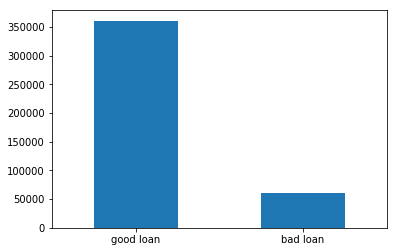

In [19]:
_ = df1['loan_status'].value_counts().plot(kind='bar')
_.set_xticklabels(['good loan', 'bad loan'], rotation=0)

#### The relationship between loan status and employment title

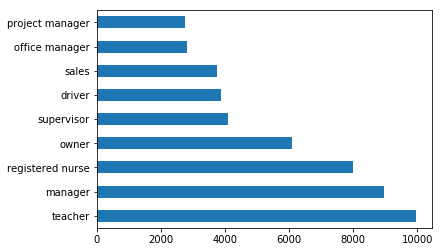

In [20]:
df1['emp_title'].value_counts()[1:10].plot(kind='barh')

In [21]:
# caculate good loan/bad loan for each employment title and their percentages
def calculation(col, col_cats):
    df2=df[df[col].isin(col_cats)][['loan_status', col]]
    good_loan_data = df2[df2.loan_status.isin(['Current', 'Fully Paid', 'In Grace Period'])]
    bad_loan_data = df2[df2.loan_status.isin(['Charged Off', 'Late (16-30 days)',
                                              'Late (31-120 days)', 'Default'])]

    good_loan = good_loan_data.groupby(col).size().values
    bad_loan = bad_loan_data.groupby(col).size().values

    totals = good_loan + bad_loan
    data1_percentages = (good_loan/totals)*100 
    data2_percentages = (bad_loan/totals)*100
    return good_loan,bad_loan,data1_percentages,data2_percentages
    

In [22]:
def plot(xticks, col, col_cats):
    
    good_loan,bad_loan,data1_percentages,data2_percentages = calculation(col, col_cats)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    # plot chart for count of loan status by col
    ax1.bar(range(len(good_loan)), good_loan, label='Good_loan', alpha=0.7, color='b')
    ax1.bar(range(len(bad_loan)), bad_loan, bottom=good_loan, label='Bad_loan', alpha=0.7, color='r')
    plt.sca(ax1)
    plt.xticks(xticks, col_cats, rotation=45, ha='right')
    ax1.set_ylabel("Count")
    ax1.set_xlabel("")
    ax1.set_title("Count of loan status by {}".format(col),fontsize=14)
    plt.legend(loc='upper right')

    # plot chart for percentage of loan status by col
    ax2.bar(range(len(data1_percentages)), data1_percentages, alpha=0.7, color='b')
    ax2.bar(range(len(data2_percentages)), data2_percentages, bottom=data1_percentages, alpha=0.7, color='r')
    plt.sca(ax2)
    plt.xticks(xticks, col_cats, rotation=45, ha='right')
    ax2.set_ylabel("Percentage")
    ax2.set_xlabel("")
    ax2.set_title("% of loan status by {}".format(col),fontsize=14)

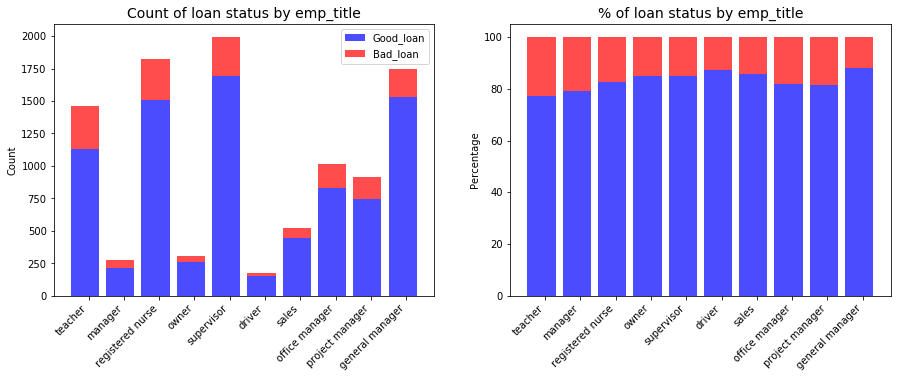

In [23]:
xticks = [0.1, 1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1, 8.1, 9.1]
emp_title_categories = ['teacher','manager','registered nurse', 'owner','supervisor','driver','sales','office manager',
        'project manager','general manager']
plot(xticks,'emp_title', emp_title_categories)

#### The relationship beween loan status and home ownership

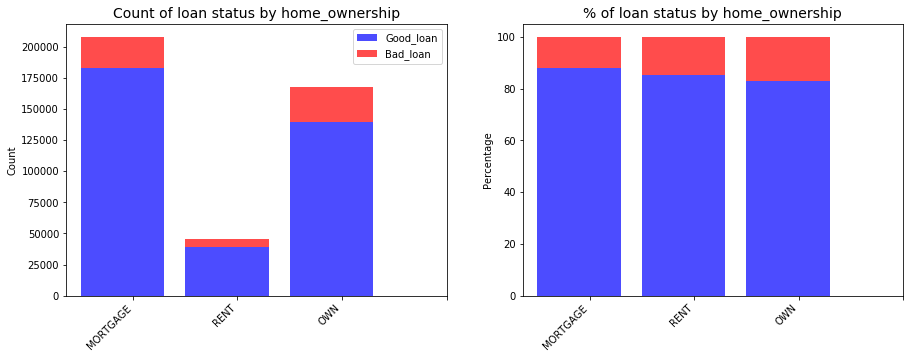

In [24]:
xticks = [0.1, 1.1, 2.1, 3.1]
home_ownership_categories = ['MORTGAGE','RENT','OWN']
plot(xticks,'home_ownership', home_ownership_categories)

#### The relation ship of zip code, unemployment rate and bad loan percentage

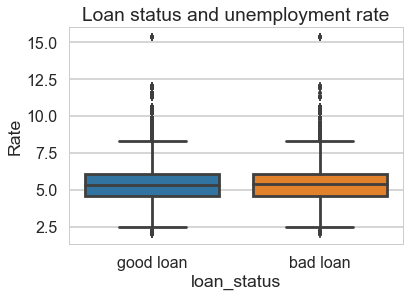

In [25]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
_ = sns.boxplot(x='loan_status', y='Rate',data=df1)
plt.title('Loan status and unemployment rate')

In [26]:
# caculation of bad loan percentage in the same zip code area
def bad_loan_perc_zip(DF):
    new1 = DF.loc[DF.loan_status == 'good loan', ['state', 'zip_code', 'Rate', 'loan_status']]
    new2 = DF.loc[DF.loan_status == 'bad loan', ['state', 'zip_code', 'Rate', 'loan_status']]

    a = pd.DataFrame(new1.groupby(['state', 'zip_code', 'Rate'])['loan_status'].size())
    a = a.reset_index()

    b = pd.DataFrame(new2.groupby(['state', 'zip_code', 'Rate'])['loan_status'].size())
    b = b.reset_index()

    total = pd.merge(a, b, on=['state','zip_code'], how='left').drop('Rate_y', axis=1)
    total.fillna(0, inplace=True)
    total['bad_loan_perc'] = (total['loan_status_y']/(total['loan_status_x'] + total['loan_status_y'])) * 100
    return total

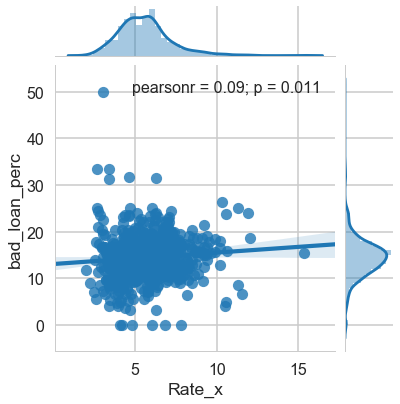

In [27]:
# plot the bad loan percentage with unemployment rate in the same zip code area
total = bad_loan_perc_zip(df1)
sns.jointplot('Rate_x', 'bad_loan_perc', data=total, kind='reg')

#### The relationship of employment length and bad loan percentage

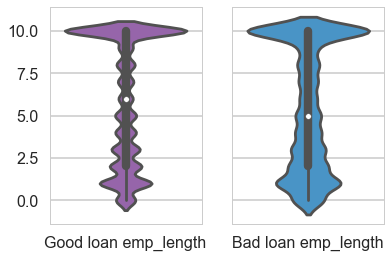

In [28]:
g_loan = df1[df1.loan_status == 'good loan'][['emp_length']]
g_loan.columns = ["Good loan emp_length"]

b_loan = df1[df1.loan_status == 'bad loan'][['emp_length']]
b_loan.columns = ["Bad loan emp_length"]

fig, axs = plt.subplots(ncols=2, sharey=True)
sns.violinplot(data=g_loan, ax=axs[0], color='#9b59b6')
sns.violinplot(data=b_loan, ax=axs[1], color='#3498db')

##### Can you count something interesting?
Teacher rank first in the top ten occupation of borrows while it has highest bad loan percentage. See plot " The relationship between loan status and employment title"

Homer owners should be rich but they seems to have higher bad loan percentage than rent people or people who have mortgage. See plot "The relationship beween loan status and home ownership"

##### Can you find some trends (high, low, increase, decrease, anomalies)?
I found the higher the unemployment rate the higher of bad loan percentage in the same zip code area. See plot "The relation ship of zip code, unemployment rate and bad loan percentage"



I made bar plot, histogram, box plot to compare two related quantities and scatterplot. And this data set I didn't made a time-series plot for the time variables are all post loan variables and they have been deleted in the data wrangling.

##### Having made these plots, what are some insights you get from them? Do you see any correlations? Is there a hypothesis you would like to investigate further? What other questions do they lead you to ask?
Insights: 
1. bad loan's percentage is about 20% in 2015.
2. Teacher rank first in the top ten occupation of borrows while they seem to have highest bad loan percentage.
3. Home owners should be rich but they seem to have higher bad loan percentage than rent people or people who have mortgage.
4. Good loan borrowers seem to have the close median of unemployment rate with bad loan borrowers.
4. To investigate the same zip code area bad loan percentage has a positive relationship with unemployment rate. The higher the unemployment rate the higher the bad loan percentage.
5. Average employment length of good loan borrowers is higher than bad loan borrowers.

Hypothesis to investigate further:
1. if the top ten employment title holders have different bad loan percentage.
2. if home ownership has effect on bad loan percentage.
3. if unemployment rate correlates with bad loan percentage in the same zip code area.
4. if the mean employment time for good loan borrowers differs from bad loan borrowers.
       

##### By now you’ve asked a bunch of questions, and found some neat insights. Is there an interesting narrative, a way of presenting the insights using text and plots from the above, that tells a compelling story? As you work out this story, what are some other trends/relationships you think will make it more complete?

Story: Bad loan percentage is still high in 2015(20%). Bad loan seems to have shorter employment length, to be a home owner or to work as a teacher. Bad loan percentage seems to increase with the unemployment rate in the same zip code area.

To work out the story I need to do statistical testing to test the trends. And I also need to investigate the relationsip between the numerical variables to see if they are correlated. Finally I will build a model to predict loan status.

## Statistical Analysis

### Numeric variables correlation analysis

In [29]:
# calculate correlation coefficient of the numeric variables
num_df = df.select_dtypes(include=['float']).copy()
cor = num_df.corr()

# find the highly correlated variables
cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
cor = pd.DataFrame(cor.stack())
cor.rename(columns = {0 :'correlation'}, inplace = True)
cor_75 = cor[(cor.correlation > 0.75) | (cor.correlation < -0.75)]
cor_75 = cor_75.reset_index()
cor_75.rename(columns={'level_0':'variable_0', 'level_1':'variable_1'}, inplace=True)
cor_75.head()

,variable_0,variable_1,correlation
0,funded_amnt,loan_amnt,1.000000
1,funded_amnt_inv,loan_amnt,0.999994
2,funded_amnt_inv,funded_amnt,0.999994
3,open_il_24m,open_il_12m,0.760552
4,open_rv_24m,open_rv_12m,0.767262


In [30]:
#slice the first ten correlated pair of variables
a = cor_75.variable_0.values[:10]
b = cor_75.variable_1.values[:10]
c = list(a) + list(b)
c = set(c)
print(c)

{'revol_bal', 'funded_amnt', 'mths_since_recent_bc_dlq', 'open_il_12m', 'open_rv_12m', 'mths_since_last_delinq', 'open_rv_24m', 'open_il_24m', 'total_rev_hi_lim', 'avg_cur_bal', 'loan_amnt', 'acc_open_past_24mths', 'funded_amnt_inv', 'tot_cur_bal', 'mths_since_recent_revol_delinq'}


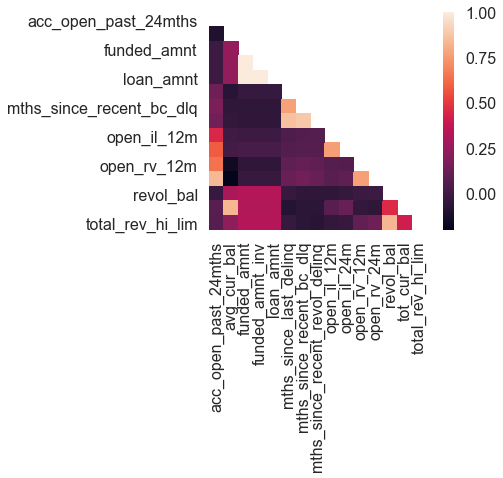

In [31]:
# correlation hotmap for the selected variables
high_cor = num_df[['acc_open_past_24mths','avg_cur_bal','funded_amnt','funded_amnt_inv','loan_amnt','mths_since_last_delinq',
 'mths_since_recent_bc_dlq','mths_since_recent_revol_delinq','open_il_12m','open_il_24m','open_rv_12m','open_rv_24m','revol_bal',
 'tot_cur_bal','total_rev_hi_lim']]
high_corr = high_cor.corr()
mask = np.zeros_like(high_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(high_corr, mask=mask, vmax=1, square=True)

The top ten employment title holders have different bad loan percentage.

Home ownership has effect on bad loan percentage.

Unemployment rate correlates with bad loan percentage in the same zip code area.

The mean employment time for good loan borrowers differs from bad loan borrowers.

### Chi squrare test for the loan status and employment title

 it tests whether the distribution of sample categorical data matches an expected distribution.

In [32]:
def create_table(DF, col, colcats): 
    df = DF[DF[col].isin(colcats)][[ 'loan_status', col]]
    Con_Table = pd.crosstab(df.loan_status, df[col], margins=True) 
    Con_Table.columns =  colcats +['row_totals']
    Con_Table.index = ['good','bad', 'col_totals']
    return Con_Table, df 

In [33]:
Con_Table, df = create_table(df1, 'emp_title', emp_title_categories)
Con_Table

,teacher,manager,registered nurse,owner,supervisor,driver,sales,office manager,project manager,general manager,row_totals
good,817,403,1319,379,987,313,1044,610,642,1162,7676
bad,3046,2159,7639,2447,5114,2421,6944,3149,3438,8794,45151
col_totals,3863,2562,8958,2826,6101,2734,7988,3759,4080,9956,52827


In [34]:
# get observed value and expected value
observed = Con_Table.iloc[0:2, 0:10]

expected =  np.outer(Con_Table["row_totals"][0:2],
                     Con_Table.iloc[2, 0:10]) / 52827

expected = pd.DataFrame(expected)

expected.columns = emp_title_categories
expected.index = ['good','bad']

expected

,teacher,manager,registered nurse,owner,supervisor,driver,sales,office manager,project manager,general manager
good,561.311223,372.270089,1301.637572,410.630473,886.50266,397.26246,1160.692222,546.199557,592.842297,1446.651447
bad,3301.688777,2189.729911,7656.362428,2415.369527,5214.49734,2336.73754,6827.307778,3212.800443,3487.157703,8509.348553


In [36]:
import scipy.stats as stats
def chi_square_test(freedom):
    # chi square statistics
    chi_squared_stat = (((observed-expected)**2)/expected).sum().sum()

    print('chi_squared_stat: ' + str(chi_squared_stat))

    crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                          df = freedom)  

    print("Critical value: " + str(crit))

    p_value = 1 - stats.chi2.cdf(x=chi_squared_stat,  # Find the p-value
                                df=freedom)
    print("P value: " + str(p_value))

chi_square_test(12)

chi_squared_stat: 269.3493768308436
Critical value: 21.0260698175
P value: 0.0


### Chi square test for loan status and home ownership

In [37]:
Con_Table, df = create_table(df1, 'home_ownership', home_ownership_categories)
Con_Table

,MORTGAGE,RENT,OWN,row_totals
good,25314,6778,28354,60446
bad,182369,38988,139290,360647
col_totals,207683,45766,167644,421093


In [38]:
# get observed value and expected value
observed = Con_Table.iloc[0:2, 0:3]

expected =  np.outer(Con_Table["row_totals"][0:2],
                     Con_Table.iloc[2, 0:3]) / 421093

expected = pd.DataFrame(expected)

expected.columns = home_ownership_categories
expected.index = ['good','bad']

In [39]:
chi_square_test(5)

chi_squared_stat: 1692.8473338733406
Critical value: 11.0704976935
P value: 0.0


### Kruskal-Wallis H-test for the median of employment length of different loan status

In [40]:
median_emp_length = df1.groupby('loan_status')['emp_length'].median()
median_emp_length

loan_status
bad loan     5.0
good loan    6.0
Name: emp_length, dtype: float64

The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal. It is a non-parametric version of ANOVA. The test works on 2 or more independent samples, which may have different sizes. Note that rejecting the null hypothesis does not indicate which of the groups differs. Post-hoc comparisons between groups are required to determine which groups are different.

In [41]:
g_loan = df1[df1.loan_status == 'good loan'][['emp_length']]
a = g_loan['emp_length']

b_loan = df1[df1.loan_status == 'bad loan'][['emp_length']]
b = b_loan['emp_length']

print("Kruskal Wallis H-test test:")

H, pval = stats.kruskal(a, b)

print("H-statistic:", H)
print("P-Value:", pval)

if pval < 0.05:
    print("Reject NULL hypothesis - Significant differences exist between groups.")
if pval > 0.05:
    print("Accept NULL hypothesis - No significant difference between groups.")

Kruskal Wallis H-test test:
H-statistic: 189435635.441
P-Value: 0.0
Reject NULL hypothesis - Significant differences exist between groups.


C:\Users\yepeng\Anaconda3\lib\site-packages\scipy\stats\stats.py:5056: RuntimeWarning: overflow encountered in long_scalars
  h = 12.0 / (totaln * (totaln + 1)) * ssbn - 3 * (totaln + 1)


### Two sample t-test for the mean of unemployment rate in good loan borrowers and bad loan borrowers

In [42]:
mean_unemp_rate = df1.groupby('loan_status')['Rate'].mean()
mean_unemp_rate 

loan_status
bad loan     5.554778
good loan    5.494133
Name: Rate, dtype: float64

In [43]:
good_loan = df1[df1.loan_status == 'good loan'][['Rate']].dropna()
x = good_loan['Rate']

bad_loan = df1[df1.loan_status == 'bad loan'][['Rate']].dropna()
y = bad_loan['Rate']

t, p = stats.ttest_ind(x, y, equal_var=False)
print("ttest_ind:            t = %g  p = %g" % (t, p))

ttest_ind:            t = -9.58285  p = 9.71499e-22


### Statistical Analysis report


1.correlation analysis

There are more than 30 pairs of numeric variables highly correlate. Among them funded_amnt/loan_amnt funded_amnt_inv/loan_amnt and funded_amnt_inv/funded_amnt's correlation coefficient are close to 1.


2.Chi squrare test for the loan status and employment title

Hypothesis

H 0  : In the population, variable'loan_status' and variable 'emp_title' are independent.
H 1  : In the population, variable'loan_status' and variable 'emp_title' are dependent. 

Test statistics

chi_squared_stat: 269.3493768308436
Critical value: 21.0260698175
P value: 0.0

Conclusion:

We reject H 0 and consider variable'loan_status' and variable 'emp_title are dependent. In other words loan status dependend on what kind of employment title of the borrowers.

3.Chi square test for loan status and home ownership

Hypothesis

H 0  : In the population, variable'loan_status' and variable 'home_ownership' are independent.
H 1  : In the population, variable'loan_status' and variable 'home_ownership' are dependent.

Test Statistics

chi_squared_stat: 1692.8473338733406
Critical value: 11.0704976935
P value: 0.0

Conclusion:

We reject H 0 and consider variable'loan_status' and variable 'home_ownership' are dependent. It means loan status dependend on whether borrowers are renting a home or have purchased house.

4.Kruskal-Wallis H-test for the median of employment length of different loan status

The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal. It is a non-parametric version of ANOVA. The test works on 2 or more independent samples, which may have different sizes. Note that rejecting the null hypothesis does not indicate which of the groups differs. Post-hoc comparisons between groups are required to determine which groups are different.

Hypothersis:

H 0: The population median of employment length in good loan borrowers and bad loan borrowers are equal.
H 1: The population median of employment length in good loan borrowers and bad loan borrowers are not equal.

Test statistics:

Kruskal Wallis H-test test:
H-statistic: 189435635.441
P-Value: 0.0

Conclusion:We reject H 0 and consider the population median of employment length in good loan borrowers and bad loan borrowers are equal. The median of good loan borrowers' employment length is higher than that of bad loan borrowers.

5. Two sample t-test for the mean of unemployment rate in good loan borrowers and bad loan borrowers

Hypothesis:

H 0: The population mean of unemployment rate of good loan borrowers and bad loan borrowers are equal.
H 1: The population mean of unemployment rate of good loan borrowers and bad loan borrowers are not equal.

Test statistics:

ttest_ind:            t = -9.58285  p = 9.71499e-22

Conclusions:

We reject H0 and consider the mean of unemployment rate of good loan borrowers is lower than that of the bad loan borrowers.